In [75]:
# Cell 1: Install & imports
!pip install -q timm transformers torch torchvision tqdm pillow

import os
import math
import timm
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoImageProcessor
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [76]:
# Cell 2: Device and hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

IMG_SIZE = 224
BATCH_SIZE = 8
NUM_CLASSES = 5      # change if your dataset has different number of classes
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 10


Device: cpu


In [77]:
# Cell 3: Attention Gate (handles spatial mismatch internally)
class AttentionGate(nn.Module):
    def __init__(self, in_channels_x, in_channels_g, inter_channels=None):
        super().__init__()
        if inter_channels is None:
            inter_channels = max(1, (in_channels_x + in_channels_g) // 8)
        self.W_x = nn.Conv2d(in_channels_x, inter_channels, kernel_size=1, bias=False)
        self.W_g = nn.Conv2d(in_channels_g, inter_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(inter_channels)
        self.relu = nn.ReLU(inplace=True)
        self.psi = nn.Conv2d(inter_channels, 1, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, g):
        # x: main feature map to modulate (B, Cx, Hx, Wx)
        # g: gating feature map (B, Cg, Hg, Wg)
        if g.shape[2:] != x.shape[2:]:
            g = F.interpolate(g, size=x.shape[2:], mode='bilinear', align_corners=False)
        x_proj = self.W_x(x)
        g_proj = self.W_g(g)
        psi = self.relu(self.bn(x_proj + g_proj))
        psi = self.psi(psi)
        attn = self.sigmoid(psi)
        return x * attn


In [78]:
# Cell 4: CvTFeatureExtractor (Hugging Face) - safely handles HF outputs
class CvTFeatureExtractor(nn.Module):
    """
    Uses Hugging Face 'microsoft/cvt-13' (or another cvt) and converts transformer tokens
    to spatial maps (B, C, H, W). Handles several HF output formats robustly.
    NOTE: This implementation converts tensors to PIL per image for the HF processor.
    """
    def __init__(self, hf_model_name="microsoft/cvt-13"):
        super().__init__()
        self.processor = AutoImageProcessor.from_pretrained(hf_model_name)
        self.model = AutoModel.from_pretrained(hf_model_name)
        self.to_pil = transforms.ToPILImage()  # converts tensor -> PIL for processor

    def forward(self, x):
        # x: tensor (B, 3, H, W), float in [0,1] or [0,255]
        # Convert batch to list[PIL]
        device = x.device
        # if input is float in 0-1 range, scale to 0-255 for ToPILImage to keep types consistent
        imgs = []
        for i in range(x.shape[0]):
            img_t = x[i].cpu()
            # ToPILImage expects 0..1 float or 0..255 uint8; it handles both
            imgs.append(self.to_pil(img_t))
        inputs = self.processor(images=imgs, return_tensors="pt").to(device)
        outputs = self.model(**inputs)

        # Safely get the main token embeddings
        # Prefer last_hidden_state, but sometimes HF returns tuple/list or direct tensor
        if hasattr(outputs, "last_hidden_state"):
            feats = outputs.last_hidden_state    # (B, N, C)
        elif isinstance(outputs, (list, tuple)):
            # pick first tensor-like element that is 3D or 4D
            found = None
            for item in outputs:
                if isinstance(item, torch.Tensor) and item.dim() in (3,4):
                    found = item
                    break
            if found is None:
                raise ValueError("CvT returned unexpected tuple without suitable tensor.")
            feats = found
        elif isinstance(outputs, torch.Tensor):
            feats = outputs
        else:
            raise ValueError(f"Unexpected CvT outputs type: {type(outputs)}")

        # If feats is (B, C, H, W) already -> return as-is
        if feats.dim() == 4:
            return feats
        # If feats is (B, N, C) convert to (B, C, H, W)
        if feats.dim() == 3:
            B, N, C = feats.shape
            H = W = int(math.sqrt(N))
            if H * W != N:
                raise ValueError(f"Cannot reshape tokens N={N} to square HxW.")
            return feats.permute(0, 2, 1).reshape(B, C, H, W)
        raise ValueError(f"Unexpected CvT feats shape: {feats.shape}")


In [79]:
# Cell 5: Dual backbone model (EfficientNet + CvT + AttentionGate)
class DualBackboneClassifier(nn.Module):
    def __init__(self, efficientnet_name='efficientnet_b0',
                 hf_cvt_model_name='microsoft/cvt-13',
                 pretrained=True, num_classes=NUM_CLASSES,
                 freeze_backbones=False, dropout=0.3):
        super().__init__()

        # EfficientNet backbone via timm (features_only -> returns list of feature maps)
        self.eff = timm.create_model(efficientnet_name, pretrained=pretrained, features_only=True)
        eff_channels = self.eff.feature_info[-1]['num_chs']  # e.g., 1280 for b0

        # CvT backbone via Hugging Face wrapped extractor
        self.cvt = CvTFeatureExtractor(hf_model_name=hf_cvt_model_name)
        cvt_channels = 384  # microsoft/cvt-13 hidden dim (common); keep explicit

        # Attention gates (cross modulation)
        self.attn_eff_by_cvt = AttentionGate(in_channels_x=eff_channels, in_channels_g=cvt_channels)
        self.attn_cvt_by_eff = AttentionGate(in_channels_x=cvt_channels, in_channels_g=eff_channels)

        # Pooling and classifier heads
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        fused_dim = eff_channels + cvt_channels
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fused_dim, fused_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(fused_dim // 2, num_classes)
        )

        # optional risk regression head
        self.risk_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fused_dim, fused_dim // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5),
            nn.Linear(fused_dim // 4, 1),
            nn.Sigmoid() 
        )





        if freeze_backbones:
            for p in self.eff.parameters(): p.requires_grad = False
            for p in self.cvt.parameters(): p.requires_grad = False

        self.eff_channels = eff_channels
        self.cvt_channels = cvt_channels

    def forward(self, x):
        # x: (B,3,H,W) normalized as during training
        eff_feats = self.eff(x)[-1]   # last stage map -> (B, C_eff, He, We)
        cvt_feats = self.cvt(x)       # (B, C_cvt, Hc, Wc)

        # Align spatial sizes before attention (make cvt -> eff size)
        if cvt_feats.shape[2:] != eff_feats.shape[2:]:
            cvt_feats = F.interpolate(cvt_feats, size=eff_feats.shape[2:], mode='bilinear', align_corners=False)

        # Cross attention
        eff_gated = self.attn_eff_by_cvt(eff_feats, cvt_feats)   # eff modulated by cvt
        cvt_gated = self.attn_cvt_by_eff(cvt_feats, eff_feats)   # cvt modulated by eff

        eff_pool = self.global_pool(eff_gated).view(x.size(0), -1)
        cvt_pool = self.global_pool(cvt_gated).view(x.size(0), -1)

        fused = torch.cat([eff_pool, cvt_pool], dim=1)
        logits = self.classifier(fused)
        risk = self.risk_head(fused).squeeze(1)

        return logits, risk


In [80]:
# Cell 6: dataset and dataloaders (ImageFolder)
DATA_DIR = "D:/cancer dataset/Data"  # expects dataset/train and dataset/val with class subfolders

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),                       # yields floats 0..1
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR, "valid"),   transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes
print("Classes:", class_names)
print("Train / Val sizes:", len(train_dataset), len(val_dataset))


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'bengin', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Train / Val sizes: 673 162


In [81]:
# Cell 7: instantiate model and print channel sizes
model = DualBackboneClassifier(
    efficientnet_name='efficientnet_b0',        # or any timm eff variant you prefer
    hf_cvt_model_name='microsoft/cvt-13',
    pretrained=True,
    num_classes=len(class_names),
    freeze_backbones=False,
    dropout=0.3
).to(device)

print("Model on", device)
print("EfficientNet channels:", model.eff_channels)
print("CvT channels:", model.cvt_channels)


Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Model on cpu
EfficientNet channels: 320
CvT channels: 384


In [82]:
# Cell 8: training & validation functions
criterion_cls = nn.CrossEntropyLoss()

def train_one_epoch(model, dataloader, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    pbar = tqdm(dataloader, desc=f"Train Epoch {epoch}")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits, _ = model(images)          # logits: (B, num_classes)
        loss = criterion_cls(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=running_correct/total)
    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validating")
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            logits, _ = model(images)
            loss = criterion_cls(logits, labels)
            running_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)
            pbar.set_postfix(val_loss=running_loss/total, val_acc=running_correct/total)
    return running_loss/total, running_correct/total


In [83]:
# Cell 9: training loop
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = None  # optionally use scheduler

best_val_acc = 0.0
train_losses, val_losses, val_accs = [], [], []

for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, epoch)
    val_loss, val_acc = validate(model, val_loader, device)
    train_losses.append(train_loss); val_losses.append(val_loss); val_accs.append(val_acc)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_dual_cvt_eff_model.pth")
        print(f"Saved best model (val_acc={best_val_acc:.4f})")


Validating: 100%|██████████| 21/21 [00:39<00:00,  1.88s/it, val_acc=0.216, val_loss=2.24]


Epoch 1: train_loss=1.0292, train_acc=0.5646 | val_loss=2.2356, val_acc=0.2160
Saved best model (val_acc=0.2160)


Validating: 100%|██████████| 21/21 [02:36<00:00,  7.46s/it, val_acc=0.352, val_loss=2.21]


Epoch 2: train_loss=0.4704, train_acc=0.8187 | val_loss=2.2130, val_acc=0.3519
Saved best model (val_acc=0.3519)


Validating: 100%|██████████| 21/21 [01:02<00:00,  2.97s/it, val_acc=0.346, val_loss=2.95]


Epoch 3: train_loss=0.2351, train_acc=0.9242 | val_loss=2.9536, val_acc=0.3457


Validating: 100%|██████████| 21/21 [00:42<00:00,  2.01s/it, val_acc=0.358, val_loss=4.06]


Epoch 4: train_loss=0.1693, train_acc=0.9376 | val_loss=4.0646, val_acc=0.3580
Saved best model (val_acc=0.3580)


Validating: 100%|██████████| 21/21 [00:35<00:00,  1.69s/it, val_acc=0.346, val_loss=3.32]


Epoch 5: train_loss=0.2081, train_acc=0.9346 | val_loss=3.3218, val_acc=0.3457


Validating: 100%|██████████| 21/21 [00:35<00:00,  1.70s/it, val_acc=0.401, val_loss=3.7] 


Epoch 6: train_loss=0.0945, train_acc=0.9747 | val_loss=3.7008, val_acc=0.4012
Saved best model (val_acc=0.4012)


Validating: 100%|██████████| 21/21 [00:35<00:00,  1.71s/it, val_acc=0.389, val_loss=3.52]


Epoch 7: train_loss=0.1206, train_acc=0.9554 | val_loss=3.5216, val_acc=0.3889


Validating: 100%|██████████| 21/21 [00:34<00:00,  1.65s/it, val_acc=0.37, val_loss=3.53] 


Epoch 8: train_loss=0.1047, train_acc=0.9658 | val_loss=3.5283, val_acc=0.3704


Validating: 100%|██████████| 21/21 [00:36<00:00,  1.74s/it, val_acc=0.414, val_loss=3.19]


Epoch 9: train_loss=0.1043, train_acc=0.9643 | val_loss=3.1888, val_acc=0.4136
Saved best model (val_acc=0.4136)


Validating: 100%|██████████| 21/21 [00:37<00:00,  1.79s/it, val_acc=0.333, val_loss=4.22]

Epoch 10: train_loss=0.1248, train_acc=0.9599 | val_loss=4.2162, val_acc=0.3333


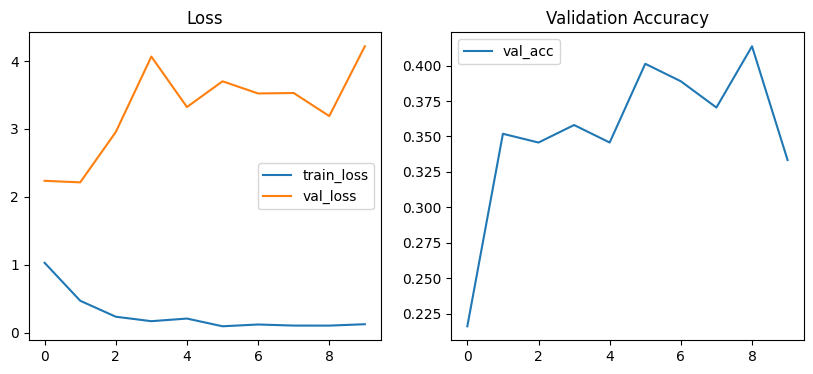

In [93]:
# Cell 10: plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(val_accs, label="val_acc")
plt.legend(); plt.title("Validation Accuracy")
plt.show()


In [94]:
# Cell 11: Save and load helpers
def save_model(path="dual_cvt_eff.pth"):
    torch.save(model.state_dict(), path)
    print("Saved:", path)

def load_model(path="dual_cvt_eff.pth", map_location=device):
    model.load_state_dict(torch.load(path, map_location=map_location))
    model.to(map_location)
    model.eval()
    print("Loaded model from", path)


In [95]:
# Cell 12: single image prediction (class + risk)
from torchvision.transforms.functional import to_pil_image

infer_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def predict_image(img_path, model, class_names, device):
    img = Image.open(img_path).convert("RGB")
    inp = infer_transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        logits, risk = model(inp)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = int(np.argmax(probs))
        conf = float(probs[pred_idx])
        risk_score = float(risk.cpu().numpy()[0])

    print(f"Predicted class: {class_names[pred_idx]} (confidence={conf:.3f})")
    print(f"Predicted risk score: {risk_score:.3f}")

    plt.imshow(img)
    plt.title(f"{class_names[pred_idx]} ({conf*100:.1f}%)\nRisk: {risk_score:.3f}")
    plt.axis('off')
    plt.show()

# Example:
# predict_image("some_test_image.png", model, class_names, device)


In [96]:
# Cell 13: Run on a folder of test images and save CSV
import pandas as pd
def batch_predict(folder, model, class_names, device):
    rows = []
    for fname in sorted(os.listdir(folder)):
        p = os.path.join(folder, fname)
        if not os.path.isfile(p): continue
        try:
            img = Image.open(p).convert("RGB")
        except:
            continue
        inp = infer_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            logits, risk = model(inp)
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
            pred_idx = int(np.argmax(probs))
            rows.append({"image": fname, "pred": class_names[pred_idx], "conf": float(probs[pred_idx]), "risk": float(risk.cpu().numpy()[0])})
    df = pd.DataFrame(rows)
    return df

# Example:
# df = batch_predict("test_folder", model, class_names, device)
# df.to_csv("preds.csv", index=False)


Predicted class: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa (confidence=0.478)
Predicted risk score: 0.646


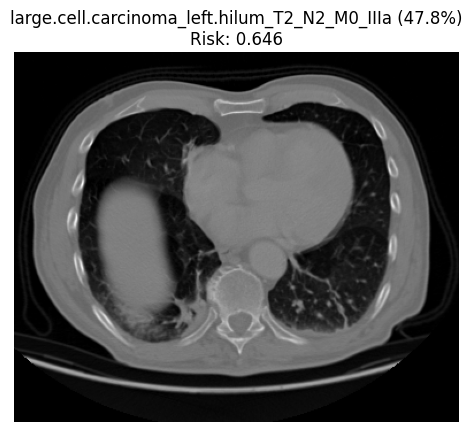

In [97]:
predict_image("D:/cancer dataset/Data/test/large.cell.carcinoma/000122.png", model, class_names, device)

Predicted class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa (confidence=0.929)
Predicted risk score: 0.587


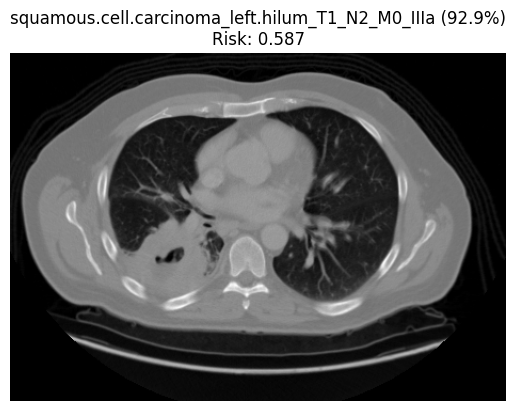

In [98]:
predict_image("D:/cancer dataset/Data/test/adenocarcinoma/000116 (7).png", model, class_names, device)

Predicted class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa (confidence=0.985)
Predicted risk score: 0.576


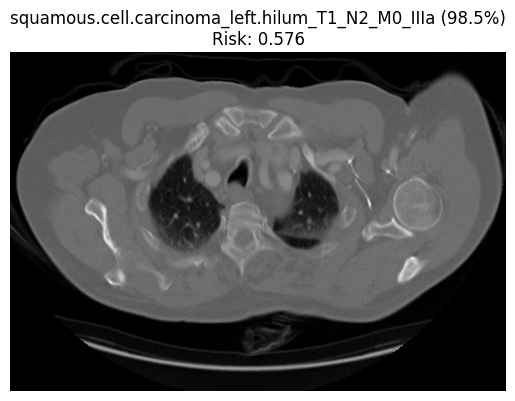

In [99]:
predict_image("D:/cancer dataset/Data/test/squamous.cell.carcinoma/000117 (5).png", model, class_names, device)

Predicted class: normal (confidence=1.000)
Predicted risk score: 0.476


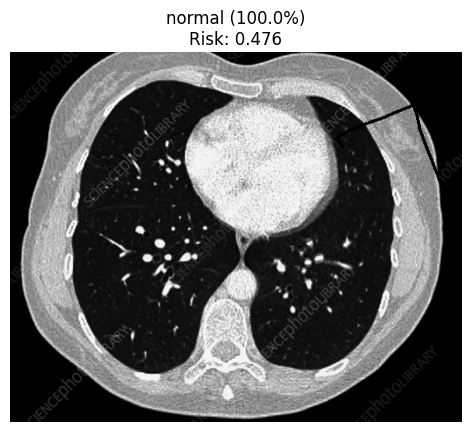

In [100]:
predict_image("D:/cancer dataset/Data/test/normal/6 - Copy (2).png", model, class_names, device)

c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📈 Model Evaluation Metrics:
Accuracy  : 0.3333
Precision : 0.2480
Recall    : 0.3333
F1 Score  : 0.2502

Detailed per-class report:

                precision    recall  f1-score   support

        Normal       0.19      0.61      0.29        23
        Benign       0.00      0.00      0.00        90
Adenocarcinoma       1.00      0.67      0.80        21
      Squamous       0.85      0.85      0.85        13
    Large_Cell       0.26      1.00      0.41        15

      accuracy                           0.33       162
     macro avg       0.46      0.62      0.47       162
  weighted avg       0.25      0.33      0.25       162



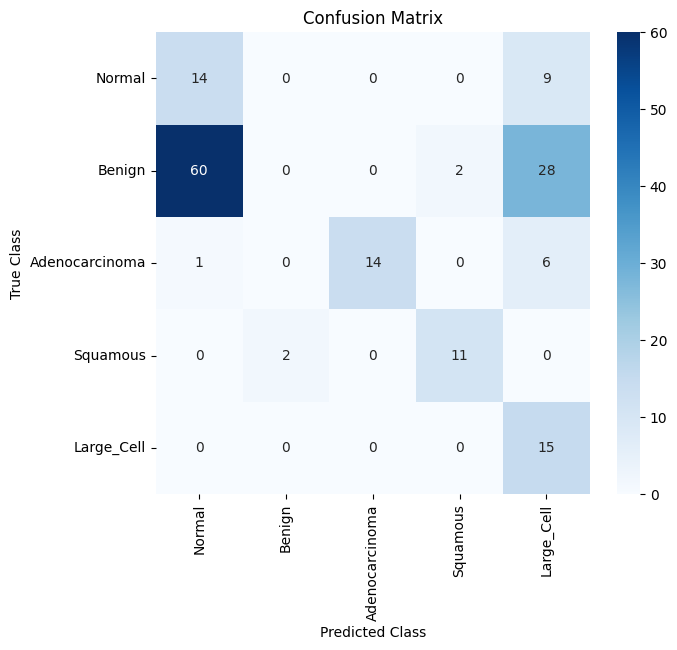

In [102]:
# 📊 Cell: Model Evaluation Metrics and Confusion Matrix

import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ✅ Make sure model is in evaluation mode
model.eval()

# Class names in the same order as training labels
class_names = ['Normal', 'Benign', 'Adenocarcinoma', 'Squamous', 'Large_Cell']

y_true, y_pred = [], []

# Disable gradient tracking for evaluation
with torch.no_grad():
    for imgs, lbls in val_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs, _ = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ✅ Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("📈 Model Evaluation Metrics:")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("\nDetailed per-class report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()


Predicted class: bengin (confidence=1.000)
Predicted risk score: 0.673


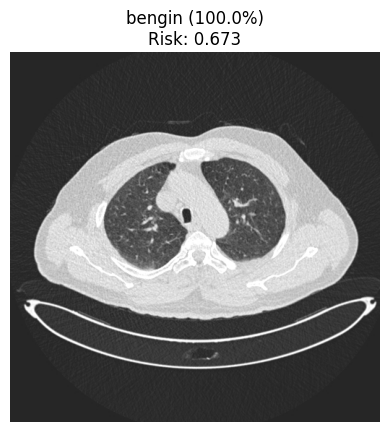

In [101]:
predict_image("D:/cancer dataset/Data/test/bengin/Bengin case (70).jpg", model, class_names, device)